# What happens to the same person over time

In this notebook, we build off our health notebook and look at the progression of one person over time.

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

# color palettes use these
cpalette = 'coolwarm' # for health associated measures. Red = bad health
meshpalette = 'BrBG_r' # complementary for the coolwarm. Use when overlaying data
defpalette = 'mako' # Use for other images.

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

encoder_models = 'cluster_gbrfs'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)
pc_df.columns = pc_df.columns.str.replace('Cluster', 'CPAF')

intcols = ['Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
pca = PCA(n_components=1)
md = metadata[intcols].dropna(subset=intcols)
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled)
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

metadata['Medications Score'] = metadata.index.map(md['Medications Score'])

# cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
print("Data Initiated!")

Data Initiated!


# People with more than one measure

In [14]:
pwcf_counts = metadata['pwCF_ID'].value_counts()
multiple_instances = metadata[metadata['pwCF_ID'].isin(pwcf_counts[pwcf_counts >= 2].index)]
multiple_instances['pwCF_ID'].value_counts()

pwCF_ID
788707     7
825012     6
785991     5
658355     5
676138     5
748699     5
698917     4
768745     4
670829     4
778851     3
770560     3
752797     3
1128691    3
698564     3
1651490    3
715927     3
701099     2
1447437    2
720054     2
748160     2
673895     2
756934     2
763742     2
650003     2
634207     2
770590     2
773911     2
1593973    2
1565754    2
Name: count, dtype: int64

### Calculate the base PCA for the figure

a) 788707; b) 825012; c) 658355; d) 676138; e) 748699; f) 785991; 


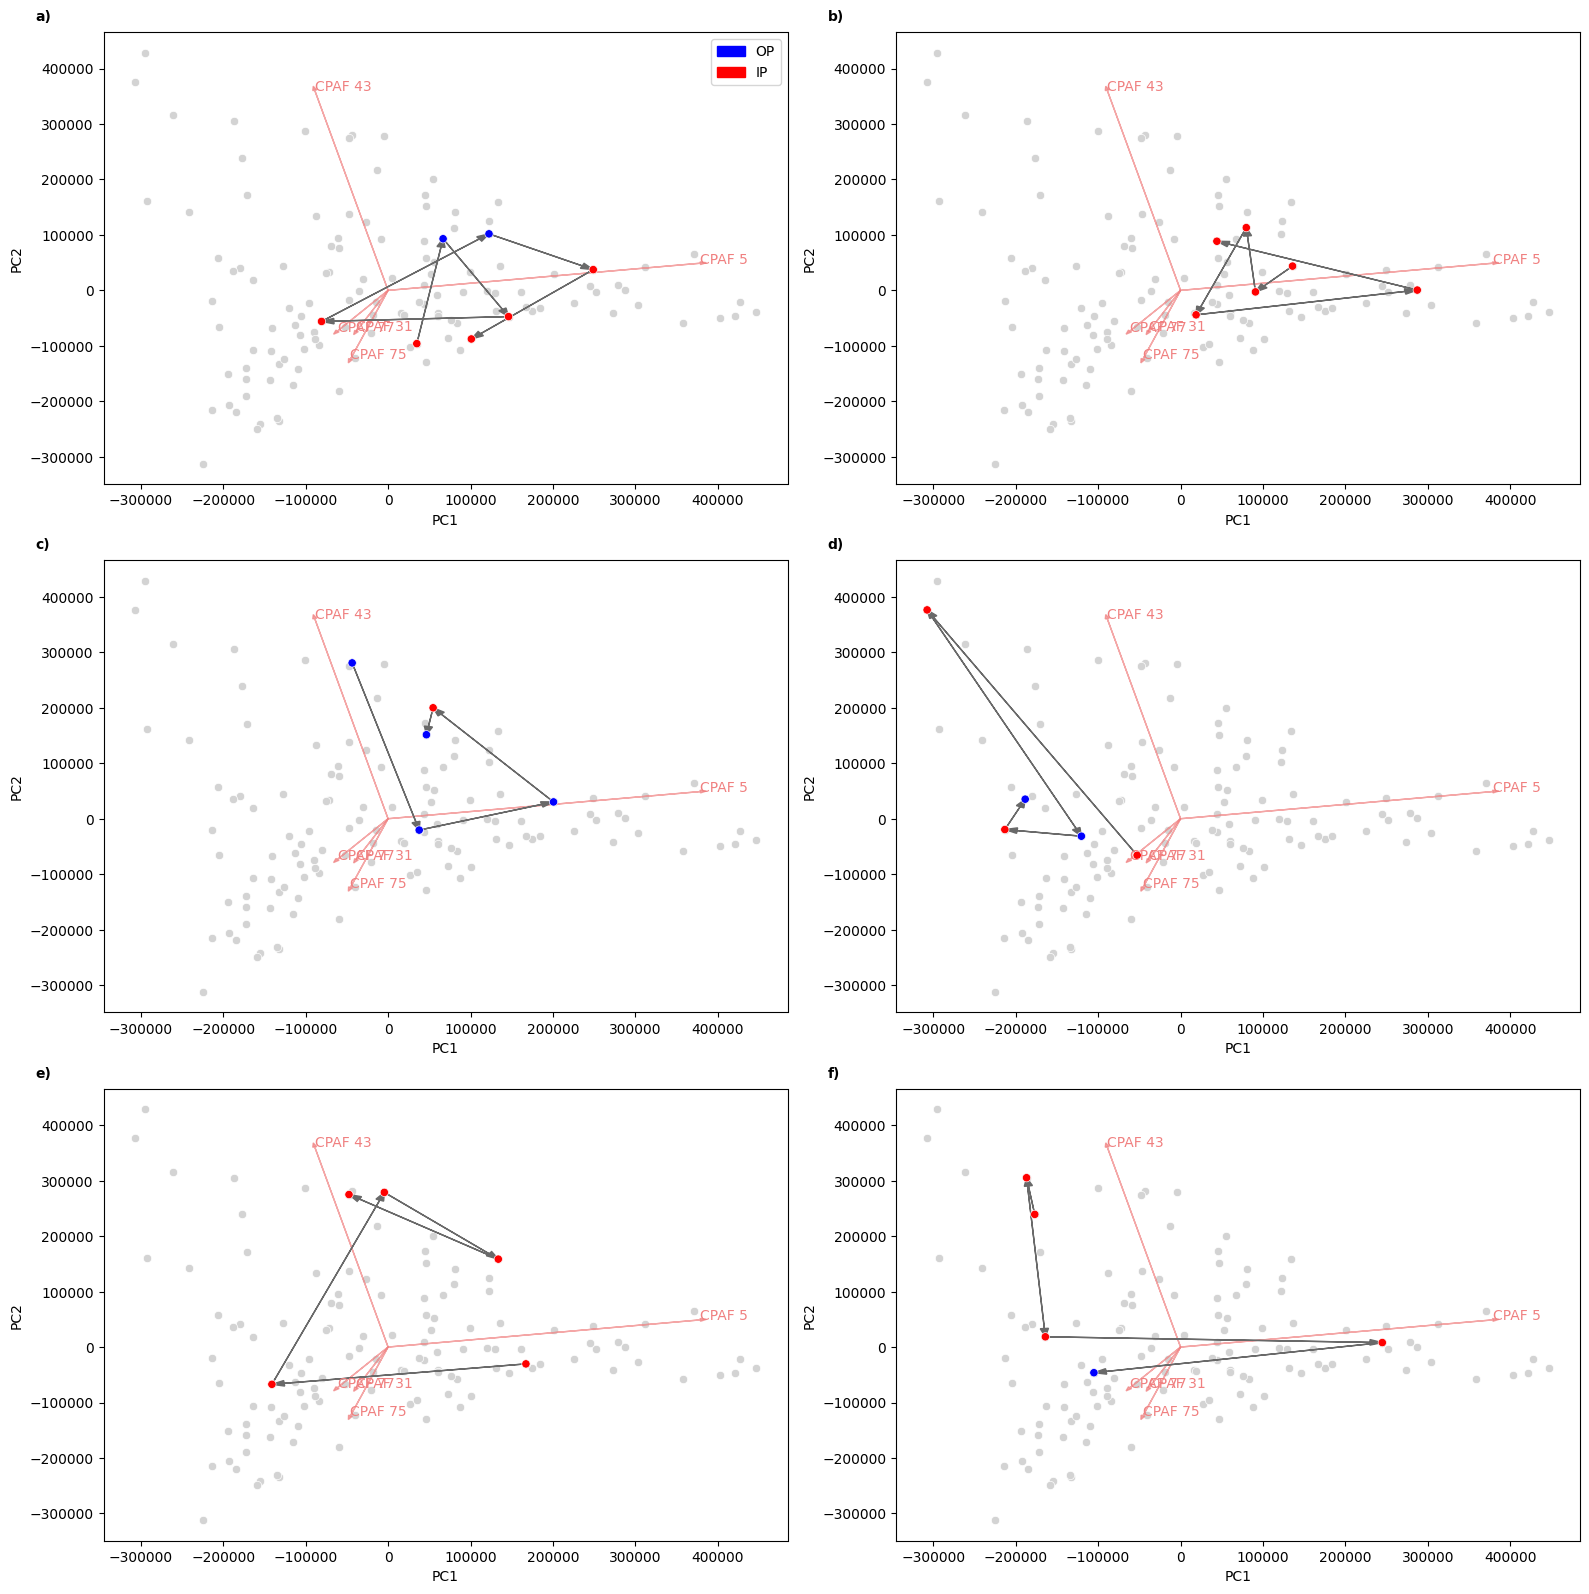

In [13]:
intcols = ['pwCF_ID', 'IP vs OP', 'FEV1/best FEV1', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'Medications Score']
intcol = 'IP vs OP'
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols)
categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)

# convert this pca into a dataframe so that we can get the components for each person.
pcaresult_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
pcaresult_df_id = pcaresult_df.join(metadata[['pwCF_ID', 'Sample date', intcol]])
loadings_df = pd.DataFrame(pca.components_.T, index=X.columns, columns=['PC1', 'PC2', 'PC3', 'PC4'])
# find the topN loadings
topN = 5
loading_magnitude = np.sum(loadings_df**2, axis=1)
top_indices = loading_magnitude.sort_values(ascending=False).index[:topN]

pc1 = 'PC1'
pc2 = 'PC2'
cmap = sns.color_palette('coolwarm', as_cmap=True)

nrows, ncols = 3, 2
interesting_pwcf = [788707, 825012, 658355, 676138, 748699, 785991]
theme_colors = sns.color_palette("mako", len(interesting_pwcf))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))
for ix, pwcf_id in enumerate(interesting_pwcf):
    row, col = divmod(ix, ncols)
    ax = axes[row, col]
    mycolor = theme_colors[ix]
    
    # start with grey dots for everyone
    g = sns.scatterplot(data=pcaresult_df, x=pc1, y=pc2, c='lightgrey', ax=ax)
    # plot the loadings on top
    sep = 400000
    for i in top_indices:
        g.arrow(0, 0, loadings_df.loc[i, pc1]*sep, loadings_df.loc[i, pc2]*sep, color='lightcoral', alpha=0.7, head_width=5000)
        g.text(loadings_df.loc[i, pc1]*sep, loadings_df.loc[i, pc2]*sep, i, color='lightcoral', fontsize=10)
    
    # subset our one person
    sub = pcaresult_df_id[pcaresult_df_id['pwCF_ID'] == pwcf_id]
    sub = sub.sort_values('Sample date')

    if len(metadata[intcol].unique()) == 2:
        grps = sorted(metadata[intcol].unique())
        if intcol == 'IP vs OP':
            grps = sorted(metadata[intcol].unique(), reverse=True)
        point_colours = ['b' if x in grps[0] else 'r' for x in sub[intcol]]
    else:
        point_colours = sub[intcol]

    
    # Draw arrows between consecutive points
    for i in range(len(sub) - 1):
        x_start, y_start = sub.iloc[i][[pc1, pc2]]
        x_end, y_end = sub.iloc[i+1][[pc1, pc2]]
        dx, dy = (x_end - x_start), (y_end - y_start)
        g.arrow(x_start, y_start, dx, dy, color='dimgrey', width=1, head_width=10000, length_includes_head=True)

    # Draw the points for this person
    g = sns.scatterplot(data=sub, x=pc1, y=pc2, c=point_colours, ax=ax)

    if ix == 0:
        legend_elements = [
            mpatches.Patch(color='blue', label=grps[0]),
            mpatches.Patch(color='red', label=grps[1])
        ]
        ax.legend(handles=legend_elements)
    #g.legend().remove()

labels = [f"{chr(97+i)})" for i in range(nrows*ncols)]
for i, (ax, label) in enumerate(zip(axes.flat, labels)):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {interesting_pwcf[i]}", end="; ")
print()

plt.tight_layout()
plt.savefig('img/individual_progression.png')
plt.show()
